Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

Chapter 4: Importing and using vector data -- the OGR library
==================================================


## Introduction

The *OGR* library is a companion library to *GDAL* that handles vector data capabilities, including information queryies, file conversions, rasterization of polygon features, polygonization of raster features, and much more. It handles popular formats including the *ESRI Shapefile*, *Keyhole Markup Language*, *PostGIS*, and *SpatiaLite*. For more information on how *OGR* came about and how it relates to *GDAL*, see here: http://trac.osgeo.org/gdal/wiki/FAQGeneral#WhatisthisOGRstuff.

In this tutorial we'll be working with: 
* [Shapely](https://shapely.readthedocs.io/en/stable/manual.html): `shapely` does things like buffers, unions, intersections, centroids, convex hulls, and lots more.
  * `shapely` is a BSD-licensed Python package for manipulation and analysis of planar geometric objects. It is based on the widely deployed GEOS (the engine of PostGIS) and JTS (from which GEOS is ported) libraries. Shapely is not concerned with data formats or coordinate systems, but can be readily integrated with packages that are.
* [Fiona](https://fiona.readthedocs.io/en/latest/): `fiona` does reading and writing data formats.
 * `fiona` is OGR's neat and nimble API for Python programmers. It focuses on reading and writing data in standard Python IO style and relies upon familiar Python types and protocols such as files, dictionaries, mappings, and iterators instead of classes specific to OGR. `fiona` can read and write real-world data using multi-layered GIS formats and zipped virtual file systems and integrates readily with other python GIS packages such as `pyproj`, `Rtree`, and `Shapely`.
* [Descartes](https://bitbucket.org/sgillies/descartes/): a simple library for plotting geometries in `matplotlib`
* [Geopandas](http://geopandas.org/): GeoPandas is an open source project to make working with geospatial data in python easier. 
  * GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.
  * The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.
* [Folium](https://github.com/python-visualization/folium): builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the leaflet.js library. 
  * Manipulate your data in Python, then visualize it in on a Leaflet map via `folium`. `folium` makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map.
  
  
  
Let's explore shapely a bit by creating some shapes:

In [287]:
import shapely
from shapely import geometry
from shapely.geometry import shape, Point, LineString, Polygon

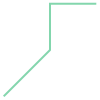

In [288]:
a = LineString([(0, 0), (1, 1), (1,2), (2,2)])
a

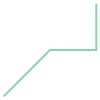

In [289]:
b = LineString([(0, 0), (1, 1), (2,1), (2,2)])
b

With these two lines created we can run some geospatial operations on them like an intersection:

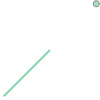

In [290]:
x = b.intersection(a)
x

We can buffer shapes too.

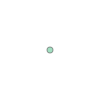

In [293]:
c = Point(1, 1)
c

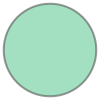

In [294]:
c = c.buffer(1.5)
c

We can do intersections:

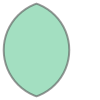

In [296]:
d = Point(2, 1).buffer(1.5)
c.intersection(d)

Or we can do a union instead of an intersection.

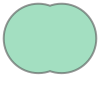

In [297]:
c.union(d)

So far we've just been using the default plotting in Jupyter notebooks. Let's shift now to plotting with matplotlib.

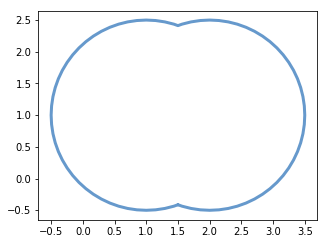

In [302]:
import matplotlib.pyplot as plt
%matplotlib inline

BLUE = '#6699cc'
GRAY = '#999999'

fig, ax = plt.subplots(figsize=(5, 5))
x, y = c.union(d).exterior.xy # find all the x and y points in the shape
ax.plot(x, y, color=BLUE, linewidth=3, solid_capstyle='round')
ax.set_aspect('equal') # make the axes equal so the shape isn't distorted
plt.show()

Now let's do something a little more complicated. We're going to plot a line and then buffer around that line in Subplot 1 and then in Subplot 2 we'll plot that buffer and then erode the buffer and plot those polygons on top of each other.

Here we'll use `descartes` to plot these polygon patches in `matplotlib`:

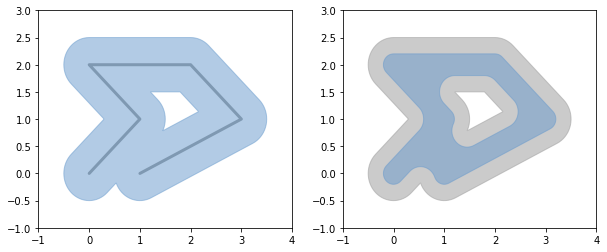

In [305]:
from descartes import PolygonPatch # this is a helpful library for plotting shapely shapes in matplotlib

# let's create a line to plot
line = LineString([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])

fig, axs = plt.subplots(1,2, figsize=(10, 4))

# Subplot # 1
axs[0].set_xlim([-1,4])
axs[0].set_ylim([-1,3])

x, y = line.xy # this gets all the points from the shapely object
axs[0].plot(x, y, color=GRAY, linewidth=3, solid_capstyle='round', zorder=1)

dilated = line.buffer(0.5) # create a dilated version of this line - note this creates a polygon
patch1 = PolygonPatch(dilated, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2) # create a PolygonPatch for easy plotting
axs[0].add_patch(patch1) # add this polygon to the plot

# Subplot # 2
axs[1].set_xlim([-1,4])
axs[1].set_ylim([-1,3])

patch2a = PolygonPatch(dilated, fc=GRAY, ec=GRAY, alpha=0.5, zorder=1)
axs[1].add_patch(patch2a)

eroded = dilated.buffer(-0.3)

# we can use shapely objects but GeoJSON-like data works as well
polygon = eroded.__geo_interface__
patch2b = PolygonPatch(polygon, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2)
axs[1].add_patch(patch2b)

In this chapter we will use an *ESRI Shapefile* that contains training data I collected for the example image we've been working on.

## Opening an *ESRI Shapefile*

Just like *GDAL* in `rasterio`, *OGR* in `fiona` abstracts the file formats so that we can use the same code for any format. It employs the same concept of a *dataset* object which we can gather information from:

### Using fiona to import shapefiles 

In [306]:
import fiona
# Open the dataset from the file
shapefile = fiona.open('../../example/rcr/rcr_training.shp')
# Make sure the dataset exists -- it would be None if we couldn't open it
if not shapefile:
    print('Error: could not open shapefile')

With our Shapefile read in, we can look at some of its properties:

In [307]:
### Let's get the driver from this file
driver = shapefile.driver
print('Dataset driver is: {n}\n'.format(n=driver))

### How many features are contained in this Shapefile?
feature_count = len(shapefile)
print('The shapefile has {n} feature(s)\n'.format(n=feature_count))

### What is the shapefiles's projection?
# Get the spatial reference
spatial_ref = shapefile.crs
print('The shapefiles spatial ref is:\n', spatial_ref, '\n')

### What is the features's geometry? is it a point? a polyline? a polygon?
geometry = feature['geometry']['type']
print("The features's geometry is: {geom}\n".format(geom=geometry))

### How many properties are in the shapefile, and what are their names?
properties = feature["properties"].keys()

# How many fields
field_count = len(properties)
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for prop in properties:
    print('\t{name}'.format(name=prop))

Dataset driver is: ESRI Shapefile

The shapefile has 65 feature(s)

The shapefiles spatial ref is:
 {'init': 'epsg:32618'} 

The features's geometry is: Polygon

Layer has 7 fields
Their names are: 
	Classcode
	Classname
	Classvalue
	RED
	GREEN
	BLUE
	Count


In [308]:
# you can get a quick view of all of this
shapefile.meta

{'driver': 'ESRI Shapefile',
 'schema': {'properties': OrderedDict([('Classcode', 'str:254'),
               ('Classname', 'str:254'),
               ('Classvalue', 'int:10'),
               ('RED', 'int:10'),
               ('GREEN', 'int:10'),
               ('BLUE', 'int:10'),
               ('Count', 'int:10')]),
  'geometry': 'Polygon'},
 'crs': {'init': 'epsg:32618'},
 'crs_wkt': 'PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]'}

The shapefile is a list of features, which can be accessed like any python list

In [309]:
feature = shapefile[0]
feature # The result is a Python dictionary

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('Classcode', None),
              ('Classname', 'Sand'),
              ('Classvalue', 2253),
              ('RED', 255),
              ('GREEN', 255),
              ('BLUE', 190),
              ('Count', 740)]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(348481.6873325305, 3841625.9444273096),
    (348470.87445113715, 3841610.6314272936),
    (348423.6331232535, 3841637.184122987),
    (348445.40837316494, 3841652.3160573784),
    (348481.6873325305, 3841625.9444273096)]]}}

As all dictionaries in Python, there are keys and values.

In [310]:
feature.keys()

dict_keys(['type', 'id', 'properties', 'geometry'])

In [311]:
feature

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('Classcode', None),
              ('Classname', 'Sand'),
              ('Classvalue', 2253),
              ('RED', 255),
              ('GREEN', 255),
              ('BLUE', 190),
              ('Count', 740)]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(348481.6873325305, 3841625.9444273096),
    (348470.87445113715, 3841610.6314272936),
    (348423.6331232535, 3841637.184122987),
    (348445.40837316494, 3841652.3160573784),
    (348481.6873325305, 3841625.9444273096)]]}}

In [312]:
print('id: ', feature['id']) #gives the id
print('Classname: ', feature['properties']['Classname']) # gives the value of the classname attribute

print('\ngeometry: ', feature['geometry']) # gives the geometry, GeoJSON format

id:  0
Classname:  Sand

geometry:  {'type': 'Polygon', 'coordinates': [[(348481.6873325305, 3841625.9444273096), (348470.87445113715, 3841610.6314272936), (348423.6331232535, 3841637.184122987), (348445.40837316494, 3841652.3160573784), (348481.6873325305, 3841625.9444273096)]]}


If you want to transform this geometry into a shapely geometry use the shape function that we imported earlier

<class 'shapely.geometry.polygon.Polygon'>


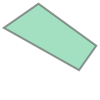

In [313]:
shapely_shape = shape(feature['geometry'])
print(type(shapely_shape))

shapely_shape

We'll come back to this set of training features later!

## Bringing in the real power tools: `geopandas`

Geopandas really takes the tools we have seen above to the next level.

The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.

From the docs:

    GeoPandas implements two main data structures, a GeoSeries and a GeoDataFrame. These are subclasses of pandas Series and DataFrame, respectively.

    A GeoSeries is essentially a vector where each entry in the vector is a set of shapes corresponding to one observation.

    A GeoDataFrame is a tabular data structure that contains a GeoSeries.

    The most important property of a GeoDataFrame is that it always has one GeoSeries column that holds a special status. This GeoSeries is referred to as the GeoDataFrame‘s “geometry”. When a spatial method is applied to a GeoDataFrame (or a spatial attribute like area is called), this commands will always act on the “geometry” column

Let's show a simple example.

In [315]:
import geopandas as gpd

p1 = Polygon([(0, 0), (1, 0), (1, 1)])
p2 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
g = gpd.GeoSeries([p1, p2, p3])
print(type(g))
g

<class 'geopandas.geoseries.GeoSeries'>


0         POLYGON ((0 0, 1 0, 1 1, 0 0))
1    POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))
2    POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))
dtype: object

Okay so that is a GeoSeries let's look at a GeoDataFrame using one of the datasets that is packaged with geopandas: a GeoDataFrame of the New York City Boroughs.

In [316]:
nybb_path = gpd.datasets.get_path('nybb')
boros = gpd.read_file(nybb_path)
print(type(boros))
boros

<class 'geopandas.geodataframe.GeoDataFrame'>


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...
2,3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...
3,1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...


Now let's plot that GeoDataFrame

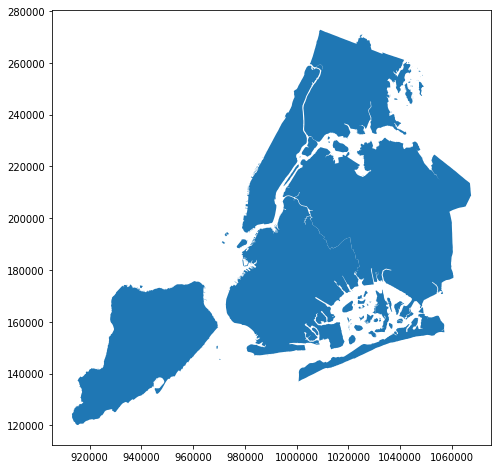

In [166]:
fig, ax = plt.subplots(figsize=(8,8))
boros.plot(ax=ax)

Pretty cool! A plot of the NYC Boroughs just like that!

We can do all the same cool geometric operations to these GeoDataFrames as we could in `shapely`, like convex hull:

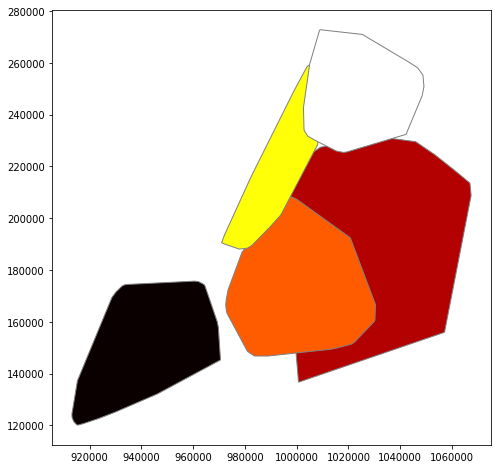

In [165]:
fig, ax = plt.subplots(figsize=(8,8))
boros.geometry.convex_hull.plot(ax=ax, cmap='hot', edgecolor='gray')

Let's look at a dataset with some more attributes, the GeoPandas pre-packaged world dataset

In [317]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


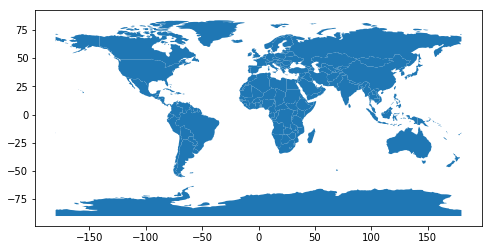

In [318]:
fig, ax = plt.subplots(figsize=(8,8)) 
world.plot(ax=ax)

With geopandas you can do filtering just like in any pandas dataframe

In [331]:
# find all countries with a population greater than 150 million
world[(world.pop_est > 150000000)]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
15,1.560509e+08,Asia,Bangladesh,BGD,224000.0,"POLYGON ((92.67272098182556 22.04123891854125,..."
22,1.987393e+08,South America,Brazil,BRA,1993000.0,POLYGON ((-57.62513342958296 -30.2162948544542...
30,1.338613e+09,Asia,China,CHN,7973000.0,(POLYGON ((110.3391878601516 18.67839508714761...
72,2.402715e+08,Asia,Indonesia,IDN,914600.0,(POLYGON ((120.7156087586305 -10.2395813940878...
73,1.166079e+09,Asia,India,IND,3297000.0,"POLYGON ((77.83745079947457 35.49400950778777,..."
122,1.762429e+08,Asia,Pakistan,PAK,427300.0,"POLYGON ((75.15802778514092 37.13303091078912,..."
168,3.139730e+08,North America,United States,USA,15094000.0,"(POLYGON ((-155.54211 19.08348000000001, -155...."


We can filter all latitudes greater than 0 leaving only the southern hemisphere

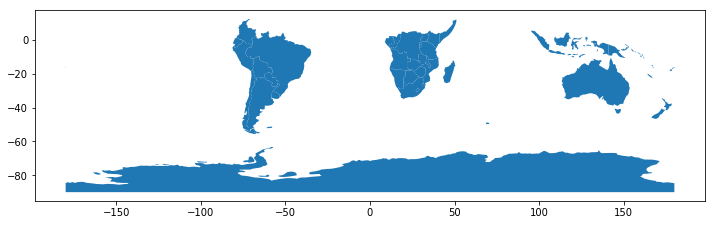

In [332]:
southern_world = world.cx[:, :0]

fig, ax = plt.subplots(figsize=(12,5)) 
southern_world.plot(ax=ax);

We can do more advanced filtering like combining the countries from each continent and then sorting continents by population.

In [333]:
world_filtered = world[['continent', 'geometry', 'pop_est']] # filter to only the columns we care about
continents = world_filtered.dissolve(by='continent', aggfunc='sum') # dissolve countries
continents

,geometry,pop_est
continent,,
Africa,(POLYGON ((49.54351891459575 -12.4698328589405...,9.932819e+08
Antarctica,(POLYGON ((-159.2081835601977 -79.497059421708...,3.802000e+03
Asia,(POLYGON ((120.7156087586305 -10.2395813940878...,4.085853e+09
Europe,(POLYGON ((-52.55642473001839 2.50470530843705...,7.281312e+08
North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1...",5.393510e+08
Oceania,(POLYGON ((173.0203747907408 -40.9190524228564...,3.351961e+07
Seven seas (open ocean),"POLYGON ((68.935 -48.62500000000001, 69.58 -48...",1.400000e+02
South America,(POLYGON ((-68.63401022758316 -52.636370458874...,3.943555e+08


It is also really simple to create Chloropleth maps (maps where the color of each shape is based on the value of an
associated variable). 

Simply use the plot command with the column argument set to the column whose values you want used to assign colors.

Let's calculate and plot by GDP per capita

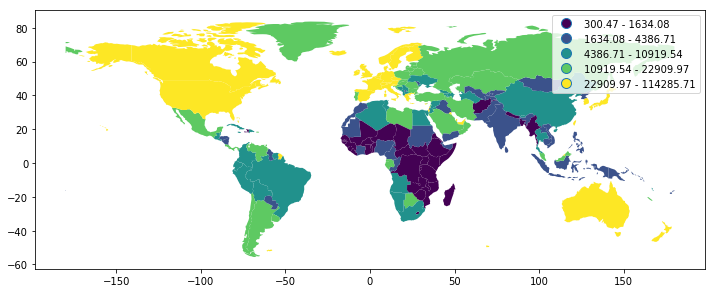

In [107]:
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est
world['gdp_per_cap'] = world['gdp_per_cap'] * 1000000 # because it was calcualted in millionths

fig, ax = plt.subplots(figsize=(12,5))
world.plot(column='gdp_per_cap', legend=True, ax=ax, scheme='quantiles') # let's also add a colorbar
# and split groups into evenly sized ones with the quantiles keyword

We can also do complicated spatial intersections and unions over large datasets. Let's load a dataset of all glaciers, intersect them with countries, and then sort to find the countries with the most glacial coverage.

In [334]:
# load in the data
# data available from http://www.naturalearthdata.com/downloads/
glaciers = gpd.read_file("../../example/ne_10m_glaciated_areas.shp")

In [335]:
# find the area containing both country and glacier
glacial_countries = gpd.overlay(world, glaciers, how='intersection') 
# this will generate an entry for each glacier and country pair
# dissolve all matching countries into one
glacial_countries = glacial_countries.dissolve(by='name_1', aggfunc='sum')
# create a column with area
glacial_countries['area'] = glacial_countries.geometry.area
# sort the dataframe by area and then display the top 5
glacial_countries.sort_values('area', ascending=False).head(5) 

,geometry,pop_est,gdp_md_est,recnum,scalerank,min_zoom,area
name_1,,,,,,,
Antarctica,(POLYGON ((-159.3970641862875 -79.510555616998...,2.281200e+05,45624.0,112531,268,256.8,5925.283952
Greenland,(POLYGON ((-53.03307044179132 67.2211367859315...,1.422720e+07,271700.0,253453,1418,1332.4,543.269290
Canada,(POLYGON ((-139.8820694652288 61.1851260437441...,1.825053e+10,708500000.0,217743,3051,2854.6,68.910882
Russia,(POLYGON ((45.60320071706292 42.56753164270239...,6.721980e+09,108768000.0,55187,231,207.2,18.457040
Norway,(POLYGON ((6.502452019146176 60.24127838749399...,3.600755e+08,21282800.0,75237,374,328.2,13.835663


Merge that glacier area / country dataset back into the world dataset with all the countries

In [336]:
glacial_world = world.merge(glacial_countries, right_on='name_1', left_on='name')

In [337]:
# reset the geometry field which is required for a GeoDataFrame
glacial_world['geometry'] = glacial_world['geometry_x']
glacial_world = gpd.GeoDataFrame(glacial_world)

Now plot it with all countries being displayed by glacier coverage:

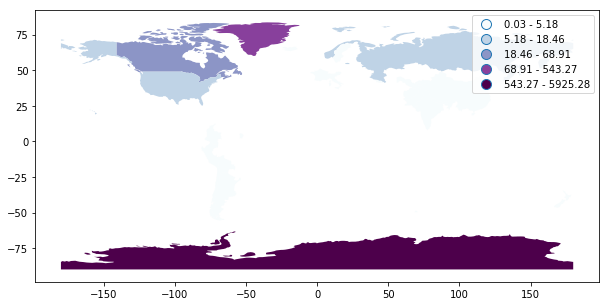

In [353]:
fig, ax = plt.subplots(figsize=(12,5))
glacial_world.plot(column='area', legend=True, ax=ax, scheme='fisher_Jenks', cmap='BuPu')

Let's take a look at some ocean data

In [354]:
# data available from http://www.naturalearthdata.com/downloads/
oceans = gpd.read_file("../../example/ne_110m_ocean.shp")

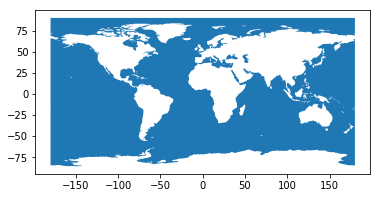

In [355]:
oceans.plot()

Let's overlay the oceans, countries, and glaciers

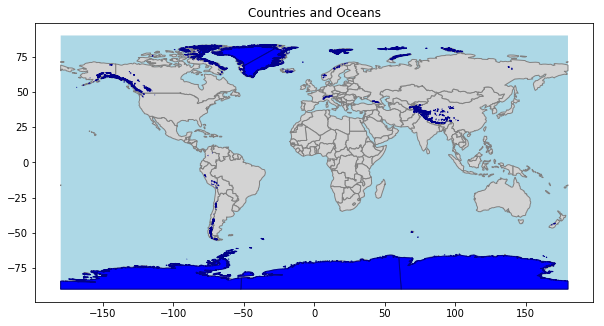

In [356]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_title('Countries and Oceans')
oceans.plot(ax=ax, facecolor='lightblue')
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
glaciers.plot(ax=ax, facecolor='blue', edgecolor='darkblue')
ax.set_aspect('equal')

Let's look at Anchorage Alaska at 61.2181° N, 149.9003° W

Note there are some mismatches between the glacier and land datasets because of the different resolutions

(-155, -145)

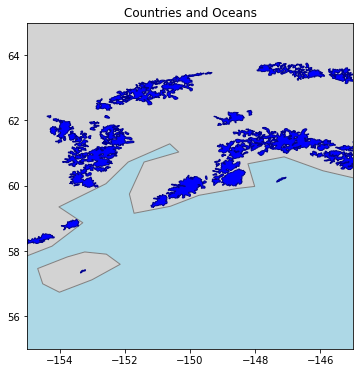

In [357]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Countries and Oceans')
oceans.plot(ax=ax, facecolor='lightblue')
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
glaciers.plot(ax=ax, facecolor='blue', edgecolor='darkblue')

# specify a location
ax.set_ylim([55, 65])
ax.set_xlim([-155, -145])

## Read from OGC WFS GeoJSON response into a GeoDataFrame

##### This example drawn from https://geohackweek.github.io/vector/04-geopandas-intro/

Use an Open Geospatial Consortium (OGC) Web Feature Service (WFS) request to obtain geospatial data from a remote source. OGC WFS is an open geospatial standard.

We won’t go into all details about what’s going on. Suffice it to say that we issue an OGC WFS request for all features from the layer named “oa:goainv” found in a GeoServer instance from NANOOS, requesting the response in GeoJSON format. Then we use the geojson package to “load” the raw response (a GeoJSON string) into a geojson feature object (a dictionary-like object).

The “oa:goainv” layer is a global dataset of monitoring sites and cruises where data relevant to ocean acidification are collected. It’s a work in progress from the Global Ocean Acidification Observation Network (GOA-ON); for additional information see the GOA-ON Data Portal.

In [213]:
import requests
import geojson

wfs_url = "http://data.nanoos.org/geoserver/ows"
params = dict(service='WFS', version='1.0.0', request='GetFeature',
              typeName='oa:goaoninv', outputFormat='json')

r = requests.get(wfs_url, params=params)
wfs_geo = geojson.loads(r.content)

Let’s examine the general characteristics of this GeoJSON object, including its __geo_interface__ interface, which we discussed earlier.

In [214]:
print(type(wfs_geo))
print(wfs_geo.keys())
print(len(wfs_geo.__geo_interface__['features']))

<class 'geojson.feature.FeatureCollection'>
dict_keys(['type', 'totalFeatures', 'crs', 'features'])
578


Now use the from_features constructor method to create a GeoDataFrame directly from the geojson.feature.FeatureCollection object.

In [215]:
wfs_gdf = gpd.GeoDataFrame.from_features(wfs_geo)

Finally, let’s visualize the data set as a simple map overlay plot; and as an example, display the values for the last feature.

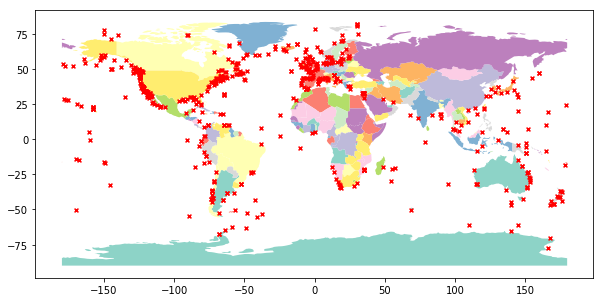

In [217]:
wfs_gdf.plot(ax=world.plot(cmap='Set3', figsize=(10, 6)),
             marker='x', markersize=15,  color='red');

In [218]:
wfs_gdf.iloc[0]

Oceans                                                    North Atlantic Ocean
additional_organizations                                                      
agency                                      Israeli Ministry of Infrastructure
city                                                                     Haifa
comments                                                                      
comments_about_overlaps                                                       
contact_email                                             jacobs1@ocean.org.il
contact_name                                                   Jacob Silverman
country                                                                 Israel
data_url                                                                      
department                                                                    
deploy_date                                                          01/2011 -
depth_range                                         

## Combining vector files with our raster data

The shapefile is already projected in the same projection that our example raster image is in, `WGS 84 / UTM zone 18N` so we won't be needing to reproject it. You *could*, however, do so using either the python [pyproj](https://jswhit.github.io/pyproj/) package.

## Tie-in with our Raster dataset

The training data we just opened contains one main field we care about:
+ a Classname field (String datatype)

Combined with the innate location information of polygons in a Shapefile, fields resemble all that we need to use for pairing labels (i.e., the integer ID and the string description) with the information in our raster.

However, in order to pair up our vector data with our raster pixels, we will need a way of co-aligning the datasets in space. 

One (complicated) way of doing this would be to manually loop through each polygon in our vector layer and determine which pixels from our raster are contained within. This approach is exactly what GIS softwares (e.g., ENVI, ArcGIS, QGIS) do when doing pairing rasters with vectors, like when doing zonal statistics.

Another less complicated way would be to use the concept of a Region of Interest (ROI) image where each non-zero pixel value in our ROI image corresponds to a raster representation of a polygon from our vector layer. In the example of our training data, most of the values would be 0 in the rasterized representation because our training data samples are small compared to the entire study area. Because we have assigned an integer ID field to each polygon, we could use these integers to store information about which polygons belong to which pixels. In this case, I have assigned values ranging from 1 - 5 for the classes:

+ 1 - forest
+ 2 - water
+ 3 - herbaceous
+ 4 - barren
+ 5 - urban

To accomplish this rasterization of a vector layer, we could use the GDAL command line utility [gdal_rasterize](http://www.gdal.org/gdal_rasterize.html), but we can stick to pure Python by using the GDAL function [gdal.RasterizeLayer](http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1).

## Let's visualize our raster and shapefile datasets together

In [399]:
import rasterio
from pyproj import Proj, transform # we will need this to convert UTM to lat, long
import numpy as np
dataset = rasterio.open('../../example/sentinel-2/2018-10-13, Sentinel-2B L1C, B08.tiff')

We showed the earlier method with fiona but geopandas has its own method for reading in a shapefile straight to a geopandas GeoDataFrame

In [360]:
shapefile = gpd.read_file('../../example/rcr/rcr_training.shp')
shapefile.head(5)

,Classcode,Classname,Classvalue,RED,GREEN,BLUE,Count,geometry
0,None,Sand,2253,255,255,190,740,"POLYGON ((348481.6873325305 3841625.94442731, ..."
1,None,Forested Wetland,2360,38,115,0,1422,"POLYGON ((347202.438243757 3842389.768595718, ..."
2,None,Scrub-Shrub Wetland,2350,170,255,0,56,"POLYGON ((348636.5240685372 3841599.796723383,..."
3,None,Scrub-Shrub Wetland,2350,170,255,0,161,"POLYGON ((349918.0539562376 3841449.721063673,..."
4,None,Scrub-Shrub Wetland,2350,170,255,0,287,"POLYGON ((349883.7204601169 3841461.460819492,..."


Let's filter the DF down to the columns we care about

In [361]:
shapefile.filter(['Classname', 'Classvalue', 'geometry']).head(5)

,Classname,Classvalue,geometry
0,Sand,2253,"POLYGON ((348481.6873325305 3841625.94442731, ..."
1,Forested Wetland,2360,"POLYGON ((347202.438243757 3842389.768595718, ..."
2,Scrub-Shrub Wetland,2350,"POLYGON ((348636.5240685372 3841599.796723383,..."
3,Scrub-Shrub Wetland,2350,"POLYGON ((349918.0539562376 3841449.721063673,..."
4,Scrub-Shrub Wetland,2350,"POLYGON ((349883.7204601169 3841461.460819492,..."


#### Okay now let's try to find the bounding box of the raster and visualize it

We could get the bounding box coordinates this way

In [400]:
dataset.bounds

BoundingBox(left=-76.716188, bottom=34.567461, right=-76.479982, top=34.730144)

These look like lat lon coordinates but let's make sure:

In [401]:
dataset.crs

CRS({'init': 'epsg:4326'})

Not very human readable... let's use pyproj to make sure:

In [402]:
Proj(dataset.crs).is_latlong()

True

Great, now let's find all four corner points by using `dataset.transform * (<pixel location>)` which allows you to input a pixel location and returns a coordinate pair in the current CRS:

In [404]:
raster_gps_points = dataset.transform * (0, 0), dataset.transform * (dataset.width, 0), dataset.transform * (dataset.width, dataset.height), dataset.transform * (0, dataset.height),

# Project all longitudes, latitudes
p1 = Proj(dataset.crs)
p2 = Proj(proj='latlong',datum='WGS84') # we want to display on folium using WGS84
p2 = Proj("+proj=utm +zone=18, +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

# use the pyproj.transform function to convert the positions to longs, lats
UTMx, UTMy = transform(p1, p2, np.array(raster_gps_points)[:,0],np.array(raster_gps_points)[:,1])

raster_utm_points = list(zip(UTMx, UTMy)) # zip up the points so they're in the form [(lat, long), ...]

print('raster bounds in UTM 18N:\n', raster_utm_points, '\n')
print('raster bounds in lat, lon:\n', raster_gps_points)

raster bounds in UTM 18N:
 [(342874.29359233467, 3844458.611782608), (364501.9870325172, 3844114.8502116846), (364236.96553226013, 3826072.8217074675), (342566.93812409707, 3826415.843995134)] 

raster bounds in lat, lon:
 ((-76.716188, 34.730144), (-76.479982, 34.730144), (-76.479982, 34.567461), (-76.716188, 34.567461))


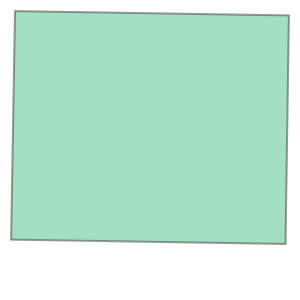

In [405]:
# we can make a simple Shapely shape out of this if we want
raster_geometry = {
    'type' : 'Polygon',
    'coordinates' : [list(raster_utm_points)]     
         }
raster_shape = shape(raster_geometry)
raster_shape

### let's overlay our raster bounds and shapefile features

In [406]:
raster_shape.exterior.xy

(array('d', [342874.29359233467, 364501.9870325172, 364236.96553226013, 342566.93812409707, 342874.29359233467]),
 array('d', [3844458.611782608, 3844114.8502116846, 3826072.8217074675, 3826415.843995134, 3844458.611782608]))

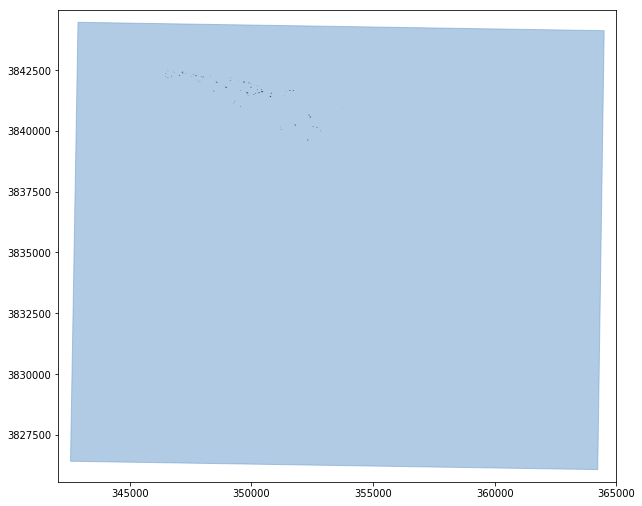

In [407]:
from descartes import PolygonPatch
import matplotlib.pyplot as plt

BLUE = '#6699cc'
GRAY = '#000000'

fig, ax = plt.subplots(figsize=(10,10))

# add raster bounds
poly1patch = PolygonPatch(raster_shape, fc=BLUE, ec=BLUE, alpha=0.5)
ax.add_patch(poly1patch)


# While we could do something like this:
#     for feat in shapefile:
#         ax.add_patch(PolygonPatch(shape(feat['geometry']), fc=GRAY, ec=GRAY, alpha=0.5, zorder=2))

# Geopandas implements this internally so all we need to do is:

shapefile.plot(ax=ax, color='black')

xrange = [int(min(raster_shape.exterior.xy[0]))-500, int(max(raster_shape.exterior.xy[0]))+500]
yrange = [int(min(raster_shape.exterior.xy[1]))-500, int(max(raster_shape.exterior.xy[1]))+500]

ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
ax.set_aspect('equal')
plt.show()

### hmm challenging to see, let's zoom in a bit

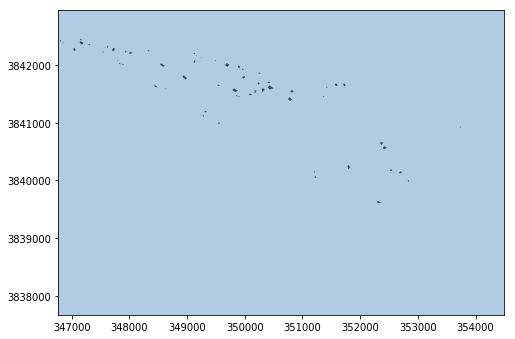

In [423]:
fig, ax = plt.subplots(figsize=(8,8))

# add raster bounds
poly1patch = PolygonPatch(raster_shape, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2)
ax.add_patch(poly1patch)

shapefile.plot(ax=ax, color='black')

xrange = [int(min(raster_shape.exterior.xy[0]))+4200, int(max(raster_shape.exterior.xy[0]))-10000]
yrange = [int(min(raster_shape.exterior.xy[1]))+11600, int(max(raster_shape.exterior.xy[1]))-1500]
ax.set_xlim(*xrange)
ax.set_ylim(*yrange)
ax.set_aspect('equal')
plt.show()

### still not extremely useful, let's make it interactive and add some class labels

In [459]:
import folium # let's make an interactive map using leaflet

# folium requires lat, long but dataset.transform outputs long, lat so reversing them:
raster_gps_reversed = list(zip(np.array(raster_gps_points)[:,1], np.array(raster_gps_points)[:,0]))

lat, long = raster_gps_reversed[0] # just to set the map center

m = folium.Map(location=[lats[2], longs[2]], zoom_start=12) # set the map centered around the first point

folium.Polygon(raster_gps_reversed, 
               popup='Planet Labs Imagery',
               color='#3186cc',
               fill=True,
               fill_color='#3186cc').add_to(m)

# there may be a more efficient way to add these, need to check recent folium updates
for index in range(0, len(shapefile)):
    feat = shapefile.iloc[index]
    feat_geom = shape(feat['geometry'])
    feat_name = feat['Classname']
    
    try:
        p1 = Proj(shapefile.crs)
        p2 = Proj(proj='latlong',datum='WGS84') # we want to display on folium using WGS84
        longs, lats = transform(p1, p2, feat_geom.exterior.xy[0], feat_geom.exterior.xy[1])
        gps_points = list(zip(lats, longs)) # zip up the points so they're in the form [(lat, long), ...]

        folium.Polygon(gps_points, 
                   tooltip=feat_name, 
                   color='#000000',
                   fill=True,
                   fill_color='#99999').add_to(m)
    except AttributeError:
        pass

m

### Now that is actually useful for exploring the dataset!

## Wrapup

Now that we have all these tools in our toolkit, we can proceed to use them for pairing our labeled polygons with the matching pixels in our Planet image to train a classifier for image classification. We continue this step in the next chapter.